In [27]:
import os
os.chdir('/engram/nklab/hossein/recurrent_models/transformer_brain_encoder/')
!pwd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
import matplotlib.pyplot as plt

import numpy as np
import torch
# import torchvision.transforms as T
from PIL import Image
import torchvision.transforms as transforms
from datasets.nsd_utils import roi_maps, plot_on_brain
from datasets.nsd import fetch_dataloaders

from brain_encoder_wrapper import brain_encoder_wrapper


/engram/nklab/hossein/recurrent_models/transformer_brain_encoder


In [41]:
#qargs = ['dinov2_q_transformer', 'dinov2_q_last', 'rois_all', 1, 0]
model = brain_encoder_wrapper()

#print all roi names
print(list(model.lh_roi_names))

Using cache found in /home/ha2366/.cache/torch/hub/facebookresearch_dinov2_main


['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'EBA', 'FBA-1', 'FBA-2', 'mTL-bodies', 'OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'mTL-words']


torch.Size([3, 425, 425])
torch.Size([3, 434, 434])


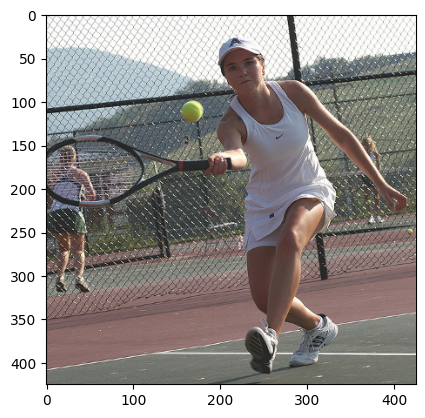

In [4]:

preprocess = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

train_img_dir  = os.path.join(model.data_dir, 'training_split', 'training_images')
image_path = train_img_dir + '/train-9039_nsd-66847.png'
image = Image.open(image_path)
plt.imshow(image)
img = preprocess(image)
print(img.shape)
patch_size = 14

size_im = (
    img.shape[0],
    int(np.ceil(img.shape[1] / patch_size) * patch_size),
    int(np.ceil(img.shape[2] / patch_size) * patch_size),
)
paded = torch.zeros(size_im)
paded[:, : img.shape[1], : img.shape[2]] = img
img = paded
print(paded.shape)
imgs = img[None, :,:,:]

h = img.shape[-2] // patch_size
w = img.shape[-1] // patch_size

# train_loader, val_loader = fetch_nsd_dataloader(args, args.batch_size, train='train')
# test_loader = fetch_nsd_dataloader(args, args.batch_size, train='test')

Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:213243): glibmm-WARNING **: 23:17:31.054: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.
(ld-linux-x86-64.so.2:213243): Pango-CRITICAL **: 23:17:31.055: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:213243): GLib-GObject-CRITICAL **: 23:17:31.055: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
(ld-linux-x86-64.so.2:213243): Pango-CRITICAL **: 23:17:31.063: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:213243): GLib-GObject-CRITICAL **: 23:17:31.064: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
** (ld-linux-x86-64.so.2:213243): WARNING **: 23:17:31.067: SPObject::updateDisplay(SPCtx *ctx, unsigned int flags) : throw in ((SPObjectClass *) G_OBJECT_GET_CLASS(this))

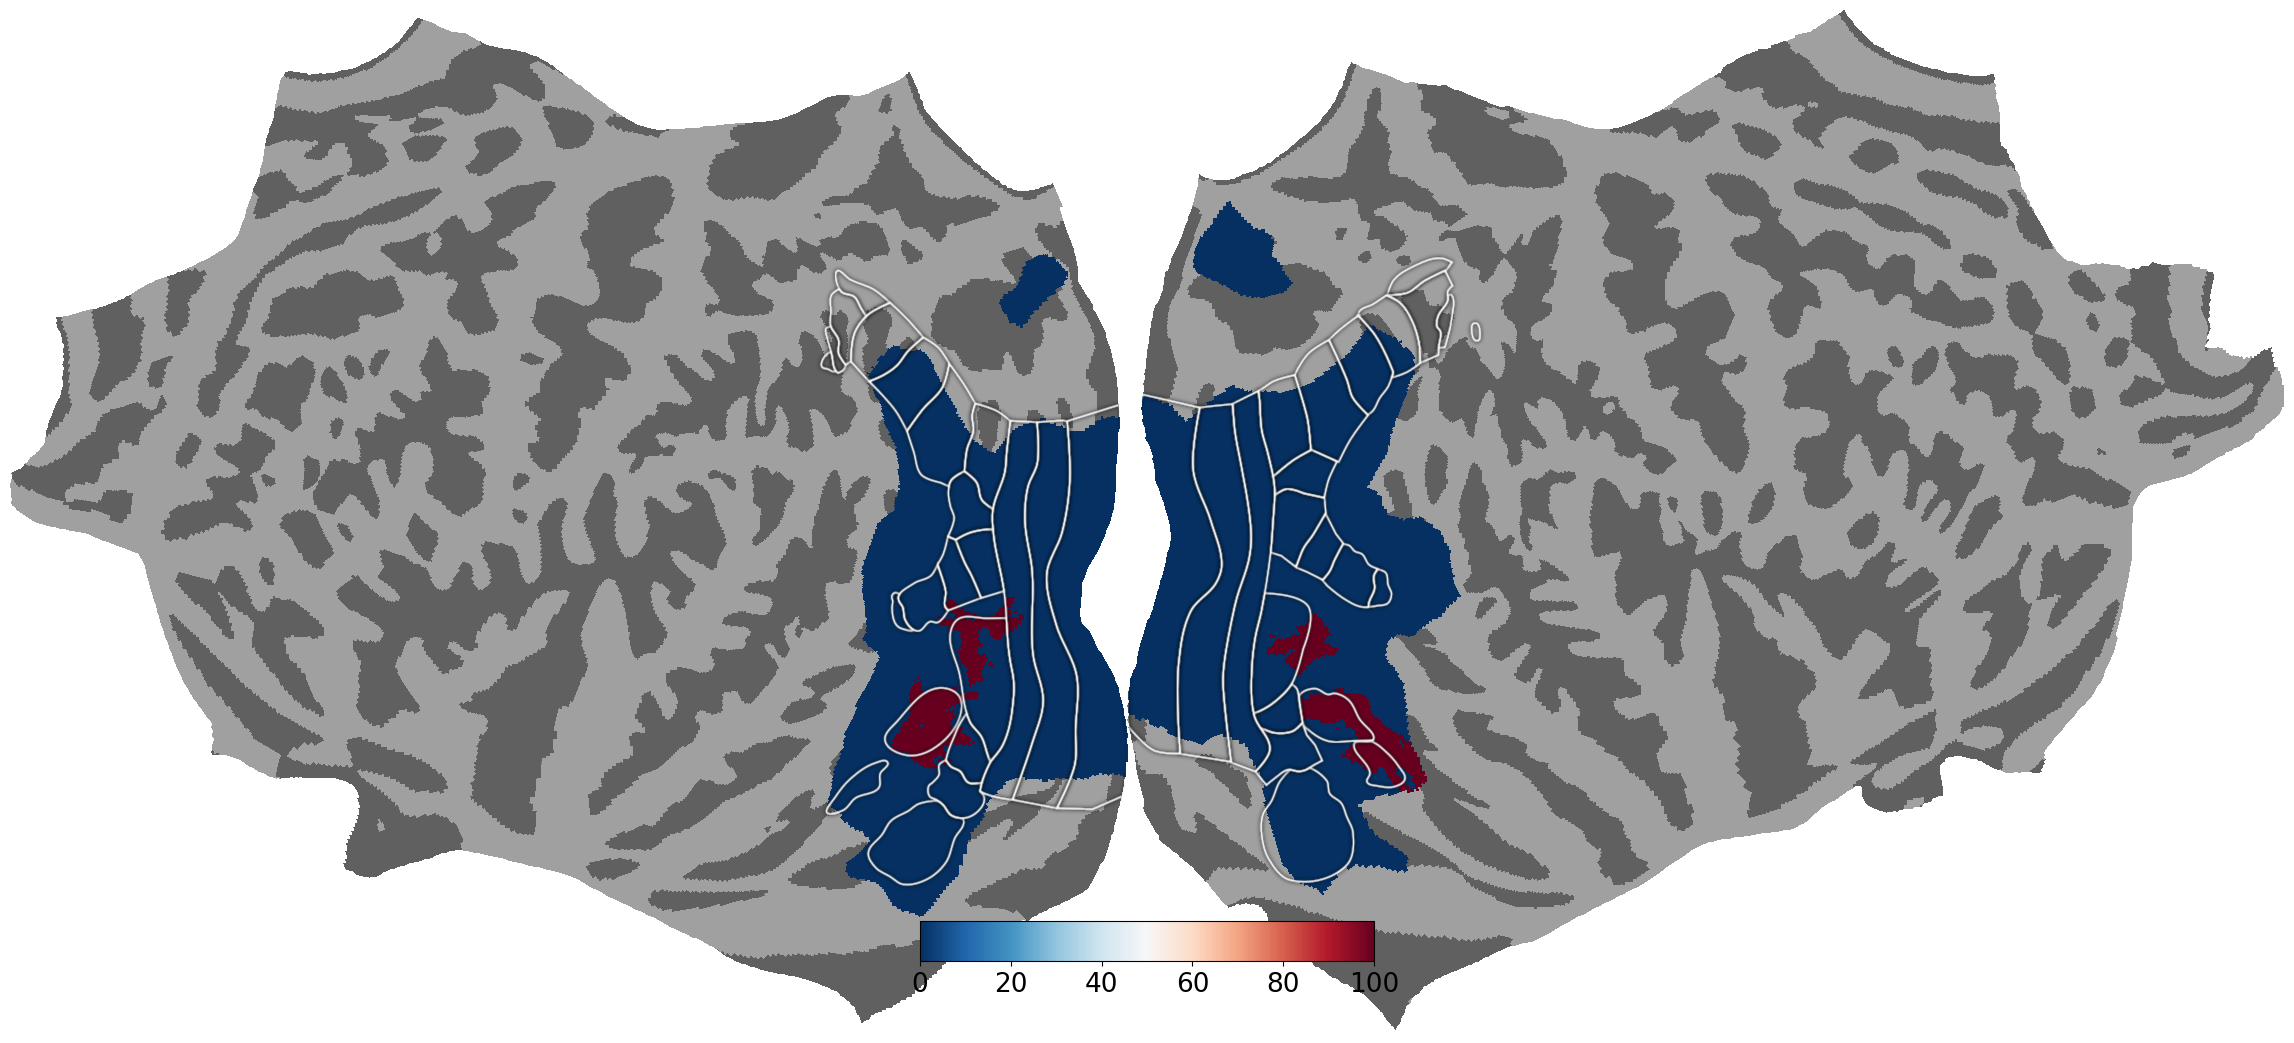

In [36]:
# list of rois to maximize activations
rois_list = ['OFA', 'FFA-1', 'FFA-2']

lh_challenge_rois = []
rh_challenge_rois = []

for roi in rois_list:
    roi_ind = model.lh_roi_names.index(roi)
    lh_challenge_rois.append(model.lh_challenge_rois[roi_ind]) 
    rh_challenge_rois.append(model.rh_challenge_rois[roi_ind])

lh_challenge_rois = torch.clip(torch.stack(lh_challenge_rois).sum(0), min=0, max=1).cpu().numpy()
rh_challenge_rois = torch.clip(torch.stack(rh_challenge_rois).sum(0), min=0, max=1).cpu().numpy()

fig = plot_on_brain(lh_challenge_rois, rh_challenge_rois)

In [37]:
outputs = model.forward(imgs)
rois_acts = np.sum(outputs[0] * lh_challenge_rois) + np.sum(outputs[1] * rh_challenge_rois)

Find images in the test set that have the highest activations in the rois

In [38]:
class model_argObj:
    def __init__(self):

        self.data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data/'
        self.backbone_arch = 'dinov2_q'
        self.train  = 'test'
        self.batch_size = 200
        self.image_size = None
        self.saved_feats = None
        self.saved_feats_dir = ''


args = model_argObj()

subj = 1
args.subj = format(subj, '02')
args.data_dir = os.path.join(args.data_dir, 'subj'+args.subj)

test_loader = fetch_dataloaders(args, train='test')
images = next(iter(test_loader))

images.shape


Test stimulus images: 159


torch.Size([159, 3, 434, 434])

In [39]:
outputs = model.forward(images)
rois_acts = np.sum(outputs[0] * lh_challenge_rois, axis=1) + np.sum(outputs[1] * rh_challenge_rois, axis=1)
rois_acts.shape

(159,)

objects that have a high correlation with face dprime


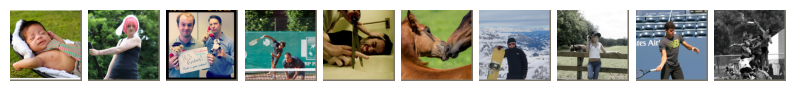

In [40]:
mean = [0.485, 0.456, 0.406]  # Mean used for normalization
std = [0.229, 0.224, 0.225]  # Standard deviation used for normalization

def denormalize(tensor):
    """Denormalizes a tensor image."""
    # Create an inverse transform
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )

    # Convert the tensor to a PIL Image
    to_pil = transforms.ToPILImage()
    image = to_pil(inv_normalize(tensor))

    return image


rois_acts_inds = np.argsort(rois_acts)
# all_corrs = all_corrs[all_corrs_inds]

top_n = 10

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 10)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(0,top_n):
    img = images[rois_acts_inds[-(i+1)]]
    ax = plt.subplot(gs[i//10,i % 10])
    ax.imshow(denormalize(img))
    ax.axis("off")

plt.show()